# Colorization by CNN

***Weikai Mao***

In [0]:
from google.colab import drive
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import cv2
import glob
import matplotlib.image as mpimg

In [0]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Implementing the components of CNN

In this section, we use the package `numpy` to implement the functions that will be used in CNN.

### Zero Padding

Zero-padding is used to pad the input volume with zeros around the border to control the spatial size of the output volumes.

In [0]:
def zero_padding(X:np.array, pad:int) -> np.array:
    """ 
    Parameters:
    X: np.array of dim (m, height, width, colorNum), X is a batch of m images.
    pad: int, the size of zero padding.
    
    Returns: 
    np.array of dim (m, height+2*pad, width+2*pad, colorNum)
    """

    return np.pad(X, ((0,0),(pad,pad),(pad,pad),(0,0)), 'constant', constant_values=(0,0))

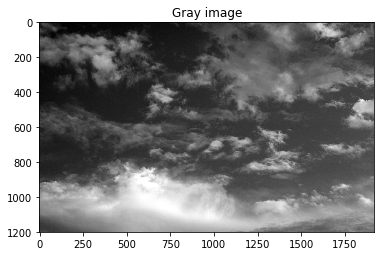

In [0]:
# rgb to grayscale
def rgb_to_gray(data):
    gray = []
    for rgb in data:
       rgb = np.dot(rgb[...,:3], [0.21, 0.72, 0.07])
       gray.append(rgb)
    return np.array(gray)


path = "/content/gdrive/My Drive/Colab Notebooks/color/sky"
data_path = os.path.join(path,'*g')
files = glob.glob(data_path)
img = mpimg.imread(files[0])
img_gray = rgb_to_gray(img)
img_gray_reshaped = img_gray.reshape((img.shape[0], img.shape[1],1))
plt.imshow(img_gray, cmap='gray')
plt.title("Gray image");

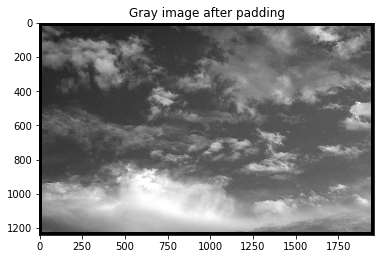

In [0]:
img_gray_reshaped = img_gray.reshape((img.shape[0], img.shape[1], 1))
img_padded_reshaped = zero_padding([img_gray_reshaped], 20)[0]
img_padded = img_padded_reshaped.reshape((img_padded_reshaped.shape[0], img_padded_reshaped.shape[1]))
plt.imshow(img_padded, cmap='gray')
plt.title("Gray image after padding");

### Single step of convolution

In [0]:
def conv_one_step(field:np.array, W:np.array, b:np.array) -> float:
    """ 
    Parameters:
    field: np.array of dim (f,f,colorNum),  it is the input data of the field,
           where f is the receptive field (window) size.
    W: np.array of dim (f,f,colorNum), weights of the field. 
    b: np.array of dim (1,1,1), bias of the field. 

    Returns:
    float, result of convolving the input field.
    """
    z = float(np.sum(field * W) + b)
    return z

### Forward pass in convolutional layer

![CNN forward pass](http://cs231n.github.io/assets/cnn/cnn.jpeg)

The input of this function is a batch of the blue cubes, and the output is a batch the following cubes.

In [0]:
def conv_forward(Z_in, W, b, stride, pad):
    """
    This function implement the forward propagation for CNN.
    
    Parameters:
    Z_in: np.array of dim (m, height_in, width_in, depth_in), input.
    W: np.array of dim (f, f, depth_in, depth_out), weights.
    b: np.array of dim (1, 1, 1, depth_out), biases.

    Returns:
    Z_out: np.array of dim (m, height_out, width_out, depth_out), output.
    memory: will be used for the function CNN_backward()
    """
    
    # set the dimensions and some parameters
    (m, height_in, width_in, depth_in) = Z_in.shape
    (f, f, depth_in, depth_out) = W.shape
    # compute the output dimensions
    height_out = int((height_in + 2 * pad - f) / stride + 1)
    width_out = int((width_in + 2 * pad - f) / stride + 1)
    # initialize the output
    Z_out = np.zeros((m, height_out, width_out, depth_out))
    # zero-pad the input 
    Z_in_padded = zero_padding(Z_in, pad)

    # iterate over all m images in the batch
    for i in range(m):
        Z_in_padded_i = Z_in_padded[i, :, :, :]
        for hgt in range(height_out):
            for wd in range(width_out):
                for dp in range(depth_out):
                    # corners of the field
                    height_begin = hgt * stride
                    height_end = height_begin + f
                    width_begin = wd * stride
                    width_end = width_begin + f
                    # take out the field
                    field = Z_in_padded_i[height_begin:height_end, width_begin:width_end, :]
                    # use the function conv_one_step to compute
                    Z_out[i, hgt, wd, dp] = conv_one_step(field, W=W[:,:,:,dp], b=b[:,:,:,dp])
    
    # verify the output dimension
    assert(Z_out.shape == (m, height_out, width_out, depth_out))
    # memory for backpropagation
    memory = (Z_in, W, b, stride, pad)

    return Z_out, memory

### Softmax function

We apply softmax function at the output layer for $K$-class classification:

$$
\hat{y}_k^{(h,w)} = \text{Softmax} (\mathbf {z}^{(h,w)} )_k={\frac {\exp(z_k^{(h,w)})} {\sum _{l=1}^{K} \exp(z_{l}^{(h,w)})}}, \\ {\text{ for }}k=1,\dotsc ,K{\text{ and }}\mathbf {z} =(z_{1},\dotsc ,z_{K})\in \mathbb {R} ^{K}.
$$

where $\hat{y}_k^{(h,w)}$ is the estimated probability of the pixel at position $(h,w)$ is of class $k$.

In [0]:
def softmax(Z: np.array) -> np.array:
  """
  Parameters: Z: np.array of dim (m, height, width, K), 
  where K is the number of classes.
  Returns: np.array of the same dim (m, height, width, K).
  """
  for i in range(Z.shape[0]):
    for h in range(Z.shape[1]):
      for w in range(Z.shape[2]):
        z = Z[i][h][w] # z is a np.array of dim K
        e_z = np.exp(z - np.max(z))
        Z[i][h][w] = e_z / e_z.sum(axis=0)
  return Z

### Loss function

We apply the categorical cross-entropy loss function for a batch of images:

$$
\text{Loss}(Y, \hat{Y}) = \frac{1}{m} \sum_{i=1}^m \text{Loss}(Y_i,\hat{Y}_i) = \frac{1}{m} \sum_{i=1}^m \Big[\frac{-1}{H_i\cdot W_i} \sum_{h,w}\sum_k y_{ik}^{(h,w)} \log \hat{y}_{ik}^{(h,w)} \Big],
$$

where $Y$ is a batch of raw images, $Y_i$ is a raw image, $\hat{Y}_i$ is the prediction, $H_i$ and $W_i$ are the height and width of this image, $k$ is the class label of the corresponding color, $y_k^{(h,w)}=1$ if the pixel at the position $(h,w)$ in the image $i$ should be classified as the class $k$, $\ y_{ik}^{(h,w)}=0$ otherwise, and $\hat{y}_{ik}^{(h,w)}$ is the estimated probability of the pixel is of the class $k$.

In [0]:
def cross_entropy(Y:np.array, Yhat:np.array) -> float:
  """
  Parameters: Y, Yhat: np.array of dim (m, height, width, K).
  Returns: float, average cross-entropy loss of one pixel in the batch.
  """
  loss_sum = 0
  for i in range(Y.shape[0]):
    loss_sum += -1/(Y.shape[1] * Y.shape[2]) * np.sum(Y[i] * np.log(Yhat[i]))
  return loss_sum / Y.shape[0]

### Partial derivatives

For briefer formulation and with loss of generality, in the math derivation below, we denote the scalar $\hat{y}_{ik}^{(h,w)}$ and scalar $z_{ik'}^{(h,w)}$ as $\hat{y}_{k}$ and $z_{k'}$ respectively. Assume all images have the same height and width, and denote them as $H$ and $W$. 

The partial derivative of the cross entropy loss:

$$
\frac{\partial \text{Loss}} {\partial \hat{y}_k} = \frac{-1}{H\cdot W} \cdot \frac{y_k}{\hat{y}_k}.
$$

The partial derivative of softmax:

If $k=k'$,

$$
% <![CDATA[
\begin{align}
\frac{\partial \hat{y}_k}{\partial z_k}
&= \frac{\partial  \frac{e^{z_k}}{\sum_{l=1}^K e^{z_l}}}{\partial z_k} \\
&= \frac{e^{z_k} \sum_{l=1}^K e^{z_l} - e^{z_k}e^{z_k}}{\left( \sum_{l=1}^K e^{z_l}\right)^2} \\
&= \frac{e^{z_k} \left( \sum_{l=1}^K e^{z_l} - e^{z_k}\right )}{\left( \sum_{l=1}^K e^{z_l}\right)^2} \\
&= \frac{ e^{z_k} }{\sum_{l=1}^K e^{z_l} } \times \frac{\left( \sum_{l=1}^K e^{z_l} - e^{z_k}\right ) }{\sum_{l=1}^K e^{z_l} } \\
&= \hat{y}_k (1-\hat{y}_k).
\end{align} %]]>
$$

For $k\neq k'$,

$$
% <![CDATA[
\begin{align}
\frac{\partial \hat{y}_k}{\partial z_{k'}}
&= \frac{\partial  \frac{e^{z_k}}{\sum_{l=1}^K e^{z_l}}}{\partial z_{k'}} \\
&= \frac{0-e^{z_k}e^{z_{k'}}}{\left( \sum_{l=1}^K e^{z_l}\right)^2} \\
&= \frac{ -e^{z_k} }{\sum_{l=1}^K e^{z_l} } \times \frac{ e^{z_{k'}} }{\sum_{l=1}^K e^{z_l} }  \\
&= - \hat{y}_k \hat{y}_{k'}.
\end{align} %]]>
$$

Thus, the partial derivative of softmax is given as

$$
% <![CDATA[
\frac{\partial \hat{y}_k}{\partial z_{k'}} = 
\begin{cases}
\hat{y}_k (1-\hat{y}_k) &  \text{if} & k=k', \\
- \hat{y}_k \hat{y}_{k'} & \text{if} & k \neq k'.
\end{cases} %]]>
$$


For row vectors $\mathbf{\hat{y}}_i^{(h,w)}$ and $\mathbf{z}_i^{(h,w)}$, they both have dimension $1*K$. 

For the same reason, we denote the scalar $\hat{y}_{ik}^{(h,w)}$ and scalar $z_{ik'}^{(h,w)}$ as $\hat{y}_{ik}$ and $z_{ik'}$ respectively.


The derivative of the cross entropy loss with respect to $\mathbf{\hat{y}}_i^{(h,w)}$:

$$
\frac{\partial \text{Loss}} {\partial \mathbf{\hat{y}}_i} = \frac{1}{H\cdot W} 
\Big(\frac{-y_{i1}}{\hat{y}_{i1}},\frac{-y_{i2}}{\hat{y}_{i2}}, ..., \frac{-y_{iK}}{\hat{y}_{iK}} \Big),
$$
which is a row vector of dimension $1*K$.


The derivative of softmax with respect to $\mathbf{z}_i^{(h,w)}$:

$$
\begin{align}
\frac{\partial \mathbf{\hat{y}}_i^{(h,w)}} {\partial \mathbf{z}_i^{(h,w)}} &= \Big[ \frac{\partial \hat{y}_{ik}}{\partial z_{ik'}} \Big]_{k,k'=1,...,K} \\
&= 
 \begin{pmatrix}
  \hat{y}_{i1}(1-\hat{y}_{i1}) & -\hat{y}_{i1}\hat{y}_{i2} & \cdots & -\hat{y}_{i1}\hat{y}_{iK} \\
  -\hat{y}_{i2}\hat{y}_{i1} & -\hat{y}_{i2}(1-\hat{y}_{i2}) & \cdots & -\hat{y}_{i2}\hat{y}_{iK} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
-\hat{y}_{iK} \hat{y}_{i1} & -\hat{y}_{iK}\hat{y}_{i2} & \cdots & \hat{y}_{iK}(1-\hat{y}_{iK})
 \end{pmatrix}
\end{align}
$$
which is a matrix of dimension $K*K$.

By the chain rule of partial derivatives, and since $\sum_{k=1}^K y_{ik}=1$, we have

$$
\frac{\partial \text{Loss}} {\partial \mathbf{z}_i^{(h,w)}} = \frac{\partial \text{Loss}} {\partial \mathbf{\hat{y}}^{(h,w)}_i} \cdot \frac{\partial \mathbf{\hat{y}}_i^{(h,w)}} {\partial \mathbf{z}_i^{(h,w)}} = \frac{1}{H\cdot W} \Big(\hat{y}^{(h,w)}_{i1}-y^{(h,w)}_{i1},  \hat{y}^{(h,w)}_{i2}-y^{(h,w)}_{i2}, \cdots, \hat{y}^{(h,w)}_{iK}-y^{(h,w)}_{iK}\Big).
$$
which is a row vector of dimension $1∗K$.

Denote the output of the last convolutional layer as $Z$, the raw images after one hot encoding as $Y$, the output of the softmax layer as $\hat{Y}$. The dimensions of $Z$, $Y$ and $\hat{Y}$ are both $m * \text{height} * \text{width} * K$. 

Therefore, 
$$
\frac{\partial Loss}{\partial Z} = \frac{1}{H\cdot W} (\hat{Y} - Y).
$$

### Initialization

We use the **Xavier** initialization. For every layer $l$: 

$$
W^{[l]} \sim N(0,1/n^{[l-1]}),\ b^{[l]}=0,
$$ 

where $n^{[l-1]}$ is the number of neurons in layer $l-1$, i.e. $\text{height}^{[l-1]} \times \text{width}^{[l-1]} \times \text{depth}^{[l-1]}$.

In [0]:
def initialize(Zi_in_shape:tuple, Zi_out_shape:tuple, f:int) -> (np.array, np.array):
  """
  Initialize weights and biases for a convolutional layer by Xavier initialization.
  
  Parameters:
  Zi_in_shape: tuple, (height_in, width_in, depth_in).
  Zi_out_shape: tuple, (height_out, width_out, depth_out).
  
FF  Returns:
  W: np.array of dim (f, f, depth_in, depth_out), weights.
  b: np.array of dim (1, 1, 1, depth_out), biases.
  """
  
  (height_in, width_in, depth_in) = Zi_in_shape
  (height_out, width_out, depth_out) = Zi_out_shape
  W = np.random.normal(loc=0, scale=1/(height_in*width_in*depth_in + height_out*width_out*depth_out), \
                       size=(f, f, depth_in, depth_out))
  b = np.zeros(shape=(1, 1, 1, depth_out))
  return W, b

### Backpropagation in a convolutional layer

By the chain rule of caculus, we implement backpropagation to do gradient descent.

In [0]:
def conv_backward(dLdZ:np.array, memory:np.array):
  """
  The dimension of this conv layer output is (m, height_out, width_out, depth_out).

  Parameters:
  dLdZ: np.array of dim (m, height_out, width_out, depth_out), 
        gradient of the loss with respect to output of the conv layer (Z).
  memory: tuple, output of the function conv_forward().

  Returns: 
  dLdZ_in: np.array of dim (m, height_in, width_in, depth_in), 
           gradient of the loss with respect to input of this conv layer.
  dLdW: np.array of dim (f, f, depth_in, depth_out), 
        gradient of loss with respect to the weights (W) of this conv layer.
  dLdb: np.array of dim (1, 1, 1, depth_out), 
        gradient of loss with respect to the biases (b) of this conv layer.
  """

  # get the dimensions and some parameters from the input parameters
  (Z_in, W, b, stride, pad) = memory
  (m, height_in, width_in, depth_in) = Z_in.shape
  (f, f, depth_in, depth_out) = W.shape
  (m, height_out, width_out, depth_out) = dLdZ.shape
  
  # initialize gradients
  dLdZ_in = np.zeros((m, height_in, width_in, depth_in))
  dLdW = np.zeros((f, f, depth_in, depth_out))
  dLdb = np.zeros((1, 1, 1, depth_out))

  # zero-padding
  Z_in_padded = zero_padding(Z_in, pad)
  dLdZ_in_padded = zero_padding(dLdZ_in, pad)

  # iterate over all m images in the batch
  for i in range(m):
    # take out the image i
    Z_in_padded_i = Z_in_padded[i,:,:,:]
    dLdZ_in_padded_i = dLdZ_in_padded[i,:,:,:]
    for hgt in range(height_out):
      for wd in range(width_out):
        for dp in range(depth_out):
          # corners of the field
          height_begin = hgt * stride
          height_end = height_begin + f
          width_begin = wd * stride
          width_end = width_begin + f
          
          # take out the field
          field = Z_in_padded_i[height_begin:height_end, width_begin:width_end, :]
          aaa = W[:,:,:,dp] * dLdZ[i, hgt, wd, dp]
          
          # Update gradients for the field
          dLdZ_in_padded_i[height_begin:height_end, width_begin:width_end, :] += \
                           W[:,:,:,dp] * dLdZ[i, hgt, wd, dp]
          dLdW[:,:,:,dp] += field * dLdZ[i, hgt, wd, dp]
          dLdb[:,:,:,dp] += dLdZ[i, hgt, wd, dp]
    
    # unpadding the image i
    shp0, shp1 = dLdZ_in_padded_i.shape[0:2]
    dLdZ_in[i,:,:,:] = dLdZ_in_padded_i[pad:shp0-pad, pad:shp1-pad, :]
  
  # verify the output dimension
  assert(dLdZ_in.shape == (m, height_in, width_in, depth_in))

  return dLdZ_in, dLdW, dLdb

## Implementing the CNN

### Building a CNN


```
[Gray images] -> [Conv1] -> [Conv2] -> [Conv3] -> [Softmax] -> [Colorized images] -> Loss
```

For a convolutional layer:

- Accepts a volume of size $W_1×H_1×D_1$.
- Requires four hyperparameters:
  - depth of the layer (number of filters) $K$;
  - receptive field size $F$;
  - stride $S$;
  - amount of zero padding $P$.
- Produces a volume of size $W_2×H_2×D_2$, where:
  - $W_2=(W_1−F+2P)/S+1$;
  - $H_2=(H_1−F+2P)/S+1$;
  - $D_2=K$.
- With parameter sharing, it introduces $F⋅F⋅D_1$ weights per filter, for a total of $(F⋅F⋅D_1)⋅K$ weights and $K$ biases.

In [0]:
def cnn_pass(images:np.array, Y:np.array, weights:np.array, biases:np.array, \
             params:tuple, shapes:tuple): 
  """
  Parameters:
  images: np.array of dim (m, height0, width0, 1), a batch of m gray images.
  Y: np.array (m, height0, width0, K), a batch of m images after one-hot encoding.
  params: tuple, the length of the tuple is the number of conv layers, 
          params = ((f1, stride1, pad1), (f2, stride2, pad2), ...).
  shapes: tuple, it is the shapes of conv layers,
          ((height1, width1, depth1), (height2, width2, depth2), ...).
  weights: np.arrray, [W1, W2, ...].
  biases: np.arrray, [b1, b2, ...].
  
  Returns:
  gradients: tuple, the length of the tuple is the number of conv layers, 
             gradients = ((dLdW1, dLdb1), (dLdW2, dLdb2), ...).
  loss: float, average training cross-entropy loss of one pixel in the batch..
  """

  # retrieve the parameters
  K = Y.shape[-1] # number of prediction classes
  m, height0, width0, depth0 = images.shape
  f1, stride1, pad1 = params[0]
  f2, stride2, pad2 = params[1]
  f3, stride3, pad3 = params[2]
  height1, width1, depth1 = shapes[0]
  height2, width2, depth2 = shapes[1]
  height3, width3, depth3 = shapes[2]
  W1, W2, W3 = weights
  b1, b2, b3 = biases


  ######################
  #### forward pass ####
  ######################

  # ----------- begin of conv layers forward operations ---------------
  # forward pass the 1st conv layer
  # Z1 is the output of the 1st conv layer
  Z1, mem1 = conv_forward(images, W1, b1, stride1, pad1) 
  Z1[Z1 < 0] = 0 # apply ReLU

  # forward pass the 2nd conv layer
  Z2, mem2 = conv_forward(Z1, W2, b2, stride2, pad2) 
  Z2[Z2 < 0] = 0 # apply ReLU

  # forward pass the 3rd conv layer
  Z3, mem3 = conv_forward(Z2, W3, b3, stride3, pad3) 
  Z3[Z3 < 0] = 0 # apply ReLU
  
  Z_last = np.copy(Z3)
  # ----------- end of conv layers forward operations ----------------

  # verify the shape
  assert(Z_last.shape == (m, height0, width0, K))
  # softmax (output) layer
  Yhat = softmax(Z_last)
  # cross-entropy loss
  loss = cross_entropy(Y, Yhat)


  #######################
  #### backward pass ####
  #######################

  dLdZ_last = Yhat - Y # gradient of loss w.r.t. last conv layer output Z_last
  dLdZ_last[Z_last < 0] = 0 # backpropagate through ReLU

  dLdWs, dLdbs = list(), list()

  # ----------- begin of conv layers backward operations ---------------
  dLdZ3 = np.copy(dLdZ_last)

  # backward pass the 3rd conv layer
  dLdZ2, dLdW3, dLdb3 = conv_backward(dLdZ3, mem3)
  assert(dLdW3.shape == (f3, f3, depth2, depth3))
  assert(dLdb3.shape == (1, 1, 1, depth3))
  dLdWs.append(dLdW3)
  dLdbs.append(dLdb3)
  dLdZ2[Z2 < 0] = 0 # backpropagate through ReLU

  # backward pass the 2nd conv layer
  dLdZ1, dLdW2, dLdb2 = conv_backward(dLdZ2, mem2)
  assert(dLdW2.shape == (f2, f2, depth1, depth2))
  assert(dLdb2.shape == (1, 1, 1, depth2))
  dLdWs.append(dLdW2)
  dLdbs.append(dLdb2)
  dLdZ1[Z1 < 0] = 0 # backpropagate through ReLU

  # backward pass the 1st conv layer
  dLdimage, dLdW1, dLdb1 = conv_backward(dLdZ1, mem1)
  assert(dLdW1.shape == (f1, f1, depth0, depth1))
  assert(dLdb1.shape == (1, 1, 1, depth1))
  dLdWs.append(dLdW1)
  dLdbs.append(dLdb1)
  # ----------- end of conv layers backward operations ---------------


  dLdWs = dLdWs[::-1] # after inverse, dLdWs = [dLdW1, dLdW2, ...]
  dLdbs = dLdbs[::-1] # after inverse, dLdbs = [dLdb1, dLdb2, ...]

  return dLdWs, dLdbs, Yhat, loss

### Gradient Descent

In [0]:
def gradient_descent(weights, biases, dLdWs, dLdbs, learning_rate:float): 
  """
  Parameters:
  The lengths of these 4 parameters are the number of conv layers, \
  which is 3 in this case.
  
  weights: np.arrray, [W1, W2, ...].
  biases: np.arrray, [b1, b2, ...].
  dLdWs: np.array, [dLdW1, dLdW2, ...].
  dLdbs: np.array, [dLdb1, dLdb2, ...].
  learning_rate: float. 

  Returns:
  New weights and biases after gradient descent. 
  """

  for l in range(len(weights)): 
    # l is the index of the conv layers, from 1 to 3 in this case
    # dLdWs[l] and weights[l] are both np.array of dim (f_l, f_l, depth_{l-1}, depth_l)

    weights[l] -= learning_rate * dLdWs[l]
    # dLdWs[l] and weights[l] are both np.array of dim (1, 1, 1, depth_l)
    biases[l] -= learning_rate * dLdbs[l]

  return weights, biases

### Training function

In [0]:
# order = np.arange(len(arr))
# np.random.shuffle(order)


def shuffle_forward(arr:np.array, order:np.array):
  return arr[order]


def shuffle_backward(arr:np.array, order:np.array):
  arr_out = np.copy(arr)
  for i, j in enumerate(order):
    arr_out[j] = arr[i]
  return arr_out

In [0]:
def train_cnn(images_all:np.array, Y:np.array, params:tuple, shapes:tuple,\
              batch_size:int, learning_rate:float=0.01, num_epochs:int=50,need_normalize=True):
  """
  images_all: np.array of dim (n, height, depth, 1), all gray images.
  Y: np.array of dim (n, height, depth, K), all images after one-hot encoding.
  params: tuple, the length of the tuple is the number of conv layers, 
          params = ((f1, stride1, pad1), (f2, stride2, pad2), ...).
  shapes: tuple, it contains the shapes of conv layers,
          ((height1, width1, depth1), (height2, width2, depth2), ...).
  """

  # normalization
  if need_normalize:
    X = (images_all - np.mean(images_all)) / np.std(images_all)
  m = batch_size
  
  f1, stride1, pad1 = params[0]
  f2, stride2, pad2 = params[1]
  f3, stride3, pad3 = params[2]

  # initialize weights and biases
  # images.shape[1:] is the shape of input layer, i.e. (height, width) of a image
  # shape[l] is the shape of l-th conv layer
  W1, b1 = initialize(images.shape[1:], shapes[0], f1)
  W2, b2 = initialize(shapes[0], shapes[1], f2)
  W3, b3 = initialize(shapes[1], shapes[2], f3)
  weights = [W1,W2,W3]
  biases = [b1,b2,b3]


  for epoch in range(num_epochs):
    # shuffle
    order = np.arange(X.shape[0])
    np.random.shuffle(order)
    X = X[order]
    Y = Y[order]

    num_batches = int(np.ceil(X.shape[0] / m))
    for b in range(num_batches):
      X_b = X[b*m : min((b+1)*m, X.shape[0])]
      Y_b = Y[b*m : min((b+1)*m, Y.shape[0])]
      
      # compute the graidents and loss
      dLdWs_b, dLdbs_b, Yhat_b, loss_b = cnn_pass(images=X_b, Y=Y_b, weights=weights, biases=biases, \
                                                  params=params, shapes=shapes)

      if epoch % 100 == 0:
      # if True:
        dLdWs_b_mean = np.mean([np.sum(d) for d in dLdWs_b])
        dLdbs_b_mean = np.mean([np.sum(d) for d in dLdbs_b])
        print(f"For {epoch+1}st epoch and {b+1}st batch, avg grd wrt W: {dLdWs_b_mean:.4f}, wrt b: {dLdbs_b_mean:.4f}, loss: {loss_b:.4f}.")
        
        if np.abs(dLdbs_b_mean) > 100:
          return weights, biases
      
      # update weights and biases by the gradients
      weights, biases = gradient_descent(weights=weights, biases=biases, dLdWs=dLdWs_b, \
                                         dLdbs=dLdbs_b, learning_rate=learning_rate)
      
      # print(cnn_predict(images, weights, biases, params))
  
  return weights, biases

### Predicting function

In [0]:
def cnn_predict(images, weights, biases, params):
  """
  Parameters:
  images: np.array of dim (m, height0, width0, 1), a batch of m gray images.
  weights: np.arrray, [W1, W2, ...].
  biases: np.arrray, [b1, b2, ...].
  params: tuple, the length of the tuple is the number of conv layers, 
          params = ((f1, stride1, pad1), (f2, stride2, pad2), ...).
  
  Returns:
  Yhat: np.array of dim (m, height0, width0, K), estimated probability.
  """
  
  m, height0, width0, _ = images.shape
  W1, W2, W3 = weights
  b1, b2, b3 = biases
  f1, stride1, pad1 = params[0]
  f2, stride2, pad2 = params[1]
  f3, stride3, pad3 = params[2]

  # ----------- begin of conv layers forward operations ---------------
  # forward pass the 1st conv layer
  # Z1 is the output of the 1st conv layer
  Z1, mem1 = conv_forward(images, W1, b1, stride1, pad1) 
  Z1[Z1 < 0] = 0 # apply ReLU

  # forward pass the 2nd conv layer
  Z2, mem2 = conv_forward(Z1, W2, b2, stride2, pad2) 
  Z2[Z2 < 0] = 0 # apply ReLU

  # forward pass the 3rd conv layer
  Z3, mem3 = conv_forward(Z2, W3, b3, stride3, pad3) 
  Z3[Z3 < 0] = 0 # apply ReLU
  
  Z_last = np.copy(Z3)
  # ----------- end of conv layers forward operations ----------------

  # softmax (output) layer
  Yhat = softmax(Z_last)

  return Yhat

### Example of using the CNN


```
params: tuple, the length of the tuple is the number of conv layers, 
        params = ((f1, stride1, pad1), (f2, stride2, pad2), ...).

shapes: tuple, it contains the shapes of conv layers,
        shapes = ((height1, width1, depth1), (height2, width2, depth2), ...).
```


In [0]:
images = np.array([[[[200], [200], [200]], 
                    [[100], [100], [100]],
                    [[100], [100], [100]]]])

Y = np.array([[[[0,1], [0,1], [0,1]], 
               [[1,0], [1,0], [1,0]],
               [[1,0], [1,0], [1,0]]]])

params=((3,1,1), (3,1,1), (3,1,1))
shapes=((3,3,4), (6,6,6), (3,3,2))

weights, biases = train_cnn(images_all=images, Y=Y, params=params, shapes=shapes, \
                            batch_size=2, learning_rate=0.01, num_epochs=301, need_normalize=True)

For 1-th epoch and 1-th batch, avg grd wrt W: -0.0052, wrt b: -0.0056, loss: 0.6931.
For 11-th epoch and 1-th batch, avg grd wrt W: -0.0099, wrt b: -0.0129, loss: 0.6728.
For 21-th epoch and 1-th batch, avg grd wrt W: -0.0212, wrt b: -0.0303, loss: 0.6598.
For 31-th epoch and 1-th batch, avg grd wrt W: -0.0407, wrt b: -0.0594, loss: 0.6513.
For 41-th epoch and 1-th batch, avg grd wrt W: -0.0724, wrt b: -0.1053, loss: 0.6455.
For 51-th epoch and 1-th batch, avg grd wrt W: -0.1252, wrt b: -0.1775, loss: 0.6407.
For 61-th epoch and 1-th batch, avg grd wrt W: -0.2190, wrt b: -0.2917, loss: 0.6351.
For 71-th epoch and 1-th batch, avg grd wrt W: -0.4067, wrt b: -0.4743, loss: 0.6253.
For 81-th epoch and 1-th batch, avg grd wrt W: -0.8551, wrt b: -0.7717, loss: 0.6046.
For 91-th epoch and 1-th batch, avg grd wrt W: -2.1505, wrt b: -1.2806, loss: 0.5564.
For 101-th epoch and 1-th batch, avg grd wrt W: -5.9649, wrt b: -2.1279, loss: 0.4210.
For 111-th epoch and 1-th batch, avg grd wrt W: -6.668

In [0]:
cnn_predict(images, weights, biases, params)

array([[[[2.26509618e-171, 1.00000000e+000],
         [1.00476568e-242, 1.00000000e+000],
         [3.60827431e-172, 1.00000000e+000]],

        [[5.98551547e-059, 1.00000000e+000],
         [3.23440780e-082, 1.00000000e+000],
         [1.44107827e-057, 1.00000000e+000]],

        [[1.00000000e+000, 5.98474279e-204],
         [1.00000000e+000, 3.62088031e-290],
         [1.00000000e+000, 5.78082562e-207]]]])

## Images preprocessing

### Resizing

In [0]:
# load image and resize
def read_img(path,size):
    data_path = os.path.join(path,'*g')
    files = glob.glob(data_path)
    data = []
    r, g, b = [], [], []
    for f1 in files:
        img = mpimg.imread(f1)
        #plt.imshow(img)
        print('Original Dimensions : ',img.shape)
        resized = cv2.resize(img,size)
        print('Dimensions : ',resized.shape)
        assert(resized.shape == (size[0],size[1],3))
        data.append(resized)
        r.append(resized[:,:,0])
        g.append(resized[:,:,1])
        b.append(resized[:,:,2])
    return np.array(data), np.array(r), np.array(g), np.array(b)

In [0]:
path = "/content/gdrive/My Drive/Colab Notebooks/color/sunrise"
size = (8,8)
k = 2
data,r,g,b = read_img(path,size)

### Color to grayscale

Convert cpolor images to gray images.

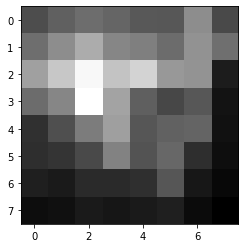

In [0]:
# rgb to grayscale
def rgb_to_gray(data):
    gray = []
    for rgb in data:
       rgb = np.dot(rgb[...,:3], [0.21, 0.72, 0.07])
       gray.append(rgb)
    return np.array(gray)

gray_data = rgb_to_gray(data)
plt.imshow(gray_data[4],cmap='gray');

### RGB to palette 

We shift this regression problem to classification problem. 

We built an palette of $K$ colors, and convert rgb values to one-hot vector. 

In [0]:
# get palatte image and its one hot encoding

# we use this package only for one-hot encoding
from keras.utils import to_categorical

def rgb_to_palette(data,k):
  #  size = (64,64)
    divider = 256 // k
    total = k*k*k  # 4*4*4
    palette = []
    one_hot_value = np.zeros((size[0],size[1],3))
    one_hot_code = []
    for rgb in data:
        one_hot_value = rgb[:,:,0]//divider + rgb[:,:,1]//divider * k + rgb[:,:,2]//divider * k * k
        one_hot_value = to_categorical(one_hot_value,num_classes = total)
        one_hot_code.append(one_hot_value)
        rgb[:,:,0] = rgb[:,:,0]//divider * divider
        rgb[:,:,1] = rgb[:,:,1]//divider * divider
        rgb[:,:,2] = rgb[:,:,2]//divider * divider
        palette.append(rgb)
    return np.array(palette), np.array(one_hot_code)

palette_data, one_hot_code = rgb_to_palette(data,k)

### Onehot to RGB

This function is used to recover one-hot vectors to rgb values.

(1280, 3)


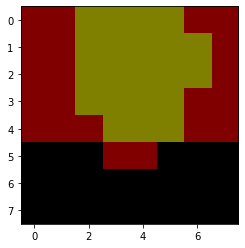

In [0]:
def onehot_to_rgb(data,k):
    divider = 256 // k
    result = []
    data = np.array(data,dtype = int)
    #last dimension index shows oringinal number
    for index in np.where(data == 1)[3]:
        b = index // (k*k) * divider
        g = (index % (k*k)) // k * divider
        r = (index % k) * divider   
        rgb = [r,g,b]
        result.append(rgb)  
    result = np.array(result)
    print(result.shape)
    return result.reshape((data.shape[0],size[0],size[1],3))
k = 2
onehot_rgb_recover = onehot_to_rgb(one_hot_code,k)
plt.imshow(onehot_rgb_recover[0]);

The image above is recovered from one-hot vector.

In [0]:
def oneHotClass_to_rgb(data,k):
    divider = 256 // k
    b = data[:,:,:,0] // (k*k) * divider
    g = (data[:,:,:,0] % (k*k)) // k * divider
    r = (data[:,:,:,0] % k) * divider  
   # r = r.reshape(r.shape[0],r.shape[1],r.shape[2],1)
   # g = g.reshape(g.shape[0],g.shape[1],g.shape[2],1)
   # b = b.reshape(b.shape[0],b.shape[1],b.shape[2],1)
    print(r.shape)
    print(g.shape)
    print(b.shape) 
    return np.stack((r,g,b),axis=3)

### LAB to palette

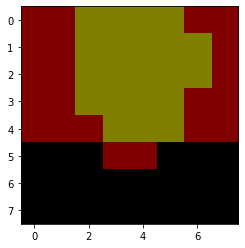

In [0]:
# return (L,A,B) of whole dataset(20,64,64,3)
def rgb_to_lab(data):
    lab_data = []
    for rgb in data:
        lab = rgb2lab(rgb)
        lab_data.append(lab[:,:,0:3])
    return np.array(lab_data)

lab_data = rgb_to_lab(data)
plt.imshow(lab2rgb(lab_data[0]));

(20, 8, 8, 64)
(20, 8, 8, 2)


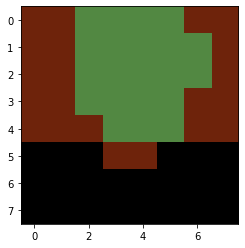

In [0]:
#input (A,B)(20,64,64,2)
#A,B is on -128,127
def lab_to_palette(data,k):
    data = data + 128 #  convert into [0,255]
    divider = 256 // k # 64
    total = k*k  # 4*4
    palette = []
    one_hot_value = data[:,:,:,0]//divider + data[:,:,:,1]//divider * k
    one_hot_code = to_categorical(one_hot_value,num_classes = total)
    print(one_hot_code.shape)
    data[:,:,:,0] = data[:,:,:,0]//divider * divider
    data[:,:,:,1] = data[:,:,:,1]//divider * divider
    print(data.shape)
    data = data - 128
    return data, np.array(one_hot_code)

k = 8
lab_palette, oneHot_lab_palette = lab_to_palette(lab_data[:,:,:,1:3],k)
#lab_data[:,:,:,0].reshape(data.shape[0],size[0],size[1],1)
lab_palette = np.stack((lab_data[:,:,:,0],lab_palette[:,:,:,0],lab_palette[:,:,:,1]), axis = 3)
plt.imshow(lab2rgb(lab_palette[0]));

### One-hot to LAB

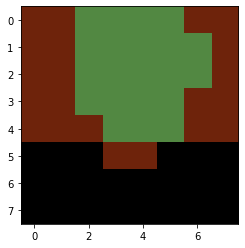

In [0]:
def onehot_to_lab(data,k):
    divider = 256 // k
    result = []
    #last dimension index shows oringinal number
    for index in np.where(data == 1)[3]:
        b = index // k * divider
        a = (index % (index // k * k)) * divider  
        b = b - 128
        a = a - 128
        ab = [a,b]
        result.append(ab)  
    result = np.array(result)
    return result.reshape((data.shape[0],size[0],size[1],2))

k = 8
onehot_lab_recover = onehot_to_lab(oneHot_lab_palette,k)
onehot_lab_recover1 = np.stack((lab_data[:,:,:,0],onehot_lab_recover[:,:,:,0],onehot_lab_recover[:,:,:,1]), axis = 3)
plt.imshow(lab2rgb(onehot_lab_recover1[0]));

The image above is recovered from one-hot vector to LAB values.

## Modeling

### Preparing images

In [0]:
X = gray_data.reshape((20,8,8,1))
Y = one_hot_code

In [0]:
print(f"The shape of X is {X.shape}, and the shape of Y is {Y.shape}")

The shape of X is (20, 8, 8, 1), and the shape of Y is (20, 8, 8, 8)


In [0]:
# split the data
Xtr, Xte = X[5:], X[:5]
Ytr, Yte = Y[5:], Y[:5]

### Training


```
params: tuple, the length of the tuple is the number of conv layers, 
        params = ((f1, stride1, pad1), (f2, stride2, pad2), ...).

shapes: tuple, it contains the shapes of conv layers,
        shapes = ((height1, width1, depth1), (height2, width2, depth2), ...).
```

Since the CNN with 3 convolutional layers is very computationally expensive, we used the images of size $8\times8$ and built a palette of $8$ colors. 

We need to predict the probability of each pixel for 8 different colors, so it is a classification problem. The shape of our input images is $8\times 8$. 

Here is the architecture of our convolutional neural network:

![CNN1](https://github.com/WalkerMao/Notes/blob/master/Pictures/ConvNN1.jpg?raw=true)


In [0]:
params = ((3,1,1), (3,1,1), (3,1,1))
shapes = ((64,64,64), (64,64,64), (8,8,8))

In [0]:
weights, biases = train_cnn(images_all=Xtr, Y=Ytr, params=params, shapes=shapes, \
                            batch_size=16, learning_rate=0.001, num_epochs=1000, need_normalize=True)

For 1st epoch and 1st batch, avg grd wrt W: -0.0000, wrt b: -0.0009, loss: 2.0794.
For 101st epoch and 1st batch, avg grd wrt W: -0.0007, wrt b: -0.4246, loss: 1.4485.
For 201st epoch and 1st batch, avg grd wrt W: -0.0220, wrt b: -9.4201, loss: 1.2683.
For 301st epoch and 1st batch, avg grd wrt W: -6.8581, wrt b: -18.5291, loss: 0.8932.
For 401st epoch and 1st batch, avg grd wrt W: -189.4674, wrt b: -5.5828, loss: 0.4168.
For 501st epoch and 1st batch, avg grd wrt W: -106.8501, wrt b: 2.6317, loss: 0.3073.
For 601st epoch and 1st batch, avg grd wrt W: -15.7538, wrt b: 0.3022, loss: 0.1273.
For 701st epoch and 1st batch, avg grd wrt W: -3.1320, wrt b: 0.3060, loss: 0.0923.
For 801st epoch and 1st batch, avg grd wrt W: -5.3055, wrt b: 0.1172, loss: 0.0734.
For 901st epoch and 1st batch, avg grd wrt W: -4.4679, wrt b: 0.0635, loss: 0.0614.


### Prediction

In [0]:
# do prediction both on training set and test set
Yhat = cnn_predict(X, weights, biases, params)

In [0]:
# convert estimated probabilitie to one-hot class
Yhat_onehot = np.copy(Yhat_tr)
for i in range(Yhat_onehot.shape[0]):
  for h in range(Yhat_onehot.shape[1]):
    for w in range(Yhat_onehot.shape[2]):
      max_prob = np.max(Yhat_onehot[i][h][w])
      Yhat_onehot[i][h][w][Yhat_onehot[i][h][w] < max_prob] = 0
      Yhat_onehot[i][h][w][Yhat_onehot[i][h][w] == max_prob] = 1

(64, 3)
(64, 3)


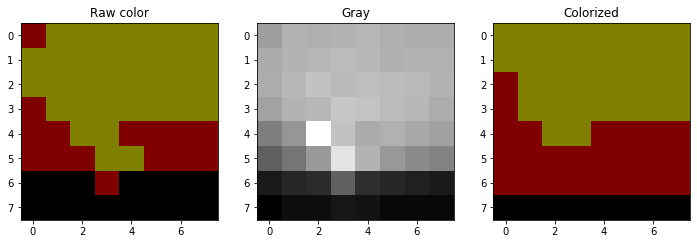

In [0]:
fig, axs = plt.subplots(1,3, figsize=(12,34))

onehot_rgb_recover = onehot_to_rgb([Ytr[5]], k=2)
axs[0].imshow(onehot_rgb_recover[0])
axs[0].set_title('Raw color')

axs[1].imshow(Xtr[5].reshape((8,8)),cmap='gray')
axs[1].set_title('Gray')

onehot_rgb_recover = onehot_to_rgb([Yhat_onehot[5]], k=2)
axs[2].imshow(onehot_rgb_recover[0])
axs[2].set_title('Colorized')

fig.show()

(64, 3)
(64, 3)


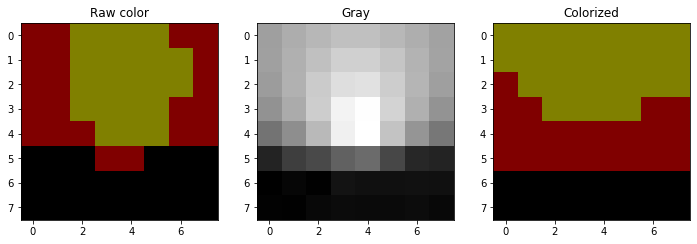

In [0]:
fig, axs = plt.subplots(1,3, figsize=(12,34))

onehot_rgb_recover = onehot_to_rgb([Ytr[0]], k=2)
axs[0].imshow(onehot_rgb_recover[0])
axs[0].set_title('Raw color')

axs[1].imshow(Xtr[0].reshape((8,8)),cmap='gray')
axs[1].set_title('Gray')

onehot_rgb_recover = onehot_to_rgb([Yhat_onehot[0]], k=2)
axs[2].imshow(onehot_rgb_recover[0])
axs[2].set_title('Colorized')

fig.show()

## Bonus

We collect some unbroken images as $Y$, then we damage the images and denote them as $X$. We need to find a model $f(\cdot)$ that makes $\hat{Y}=f(X)$ as close as possible to $Y$.


We implement a convolutional neuron network to solve this problem, and we also turn this problem to a classification by building an palette of 8 colors. At first, we fill the damaged pixels with a random color class, then iterate and minimize the cross-entropy loss.

```
[Damaged images] -> [Conv1] -> [Conv2] -> [Conv3] -> [Softmax] -> [filled images] -> Loss
```

Suppose the damage size is $4 \times 4$. Here is the architecture of this convolutional neuron network.

![CNN2](https://github.com/WalkerMao/Notes/blob/master/Pictures/ConvNN2.jpg?raw=true)

In [0]:
params = ((3,1,1), (3,1,1), (3,1,1))
shapes = ((16,16,32), (8,8,16), (4,4,8))

weights, biases = train_cnn(images_all=Xtr, Y=Ytr, params=params, shapes=shapes, \
                            batch_size=16, learning_rate=0.001, num_epochs=1000, need_normalize=True)

# do predictions
Yhat = cnn_predict(X, weights, biases, params)